In [1]:
import tensorflow_datasets as tfds

# Carga de datos
data, info = tfds.load(
    "cats_vs_dogs",
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteQWTYJ5/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [2]:
# Separación en conjuntos
X_train, X_valid, X_test = data

In [3]:
# Dimensiones
X_train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [4]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmp9b2m2hw3tfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    

>Cada imagen tiene dimensiones distintas, no se muestran

In [5]:
# Número de elementos
info.splits["train"].num_examples

23262

In [6]:
# Clases
clases = info.features["label"].names
clases

['cat', 'dog']

>23262 elementos en total entre los 3 conjuntos

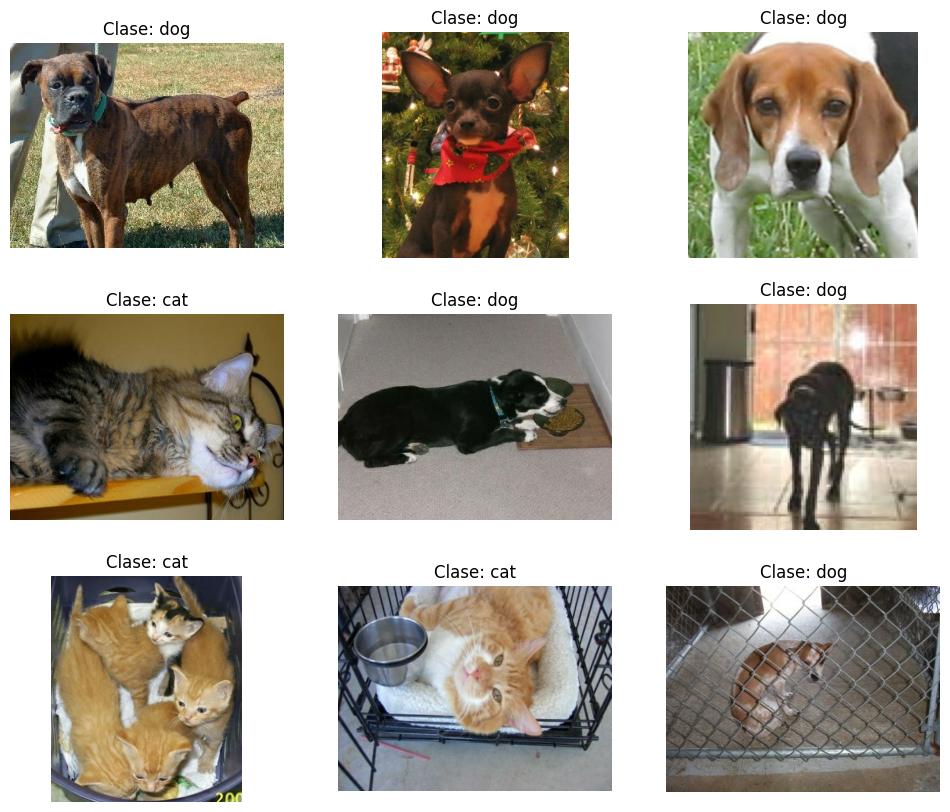

In [7]:
# Representación visual
import matplotlib.pyplot as plt

index = 0
plt.figure(figsize=(12, 10))

for image, label in X_train.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Clase: {clases[label]}")
    plt.axis("off")

plt.show()

In [8]:
# Preparación de imagenes. Redimensión, preprocesamiento para el modelo, aumento del dataset.
import tensorflow as tf

batch_size = 32
preprocess = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(height=299, width=299, crop_to_aspect_ratio=True), # Redimensionamos a 299x299
        tf.keras.layers.Lambda(tf.keras.applications.inception_v3.preprocess_input), # Preprocesamiento para modelo Inception
    ]
)

# Pipeline para aumentar el tamaño del dataset
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(mode="horizontal", seed=42), # Inversión espejo
        tf.keras.layers.RandomRotation(factor=0.05, seed=42), # Rotación
        tf.keras.layers.RandomContrast(factor=0.2, seed=42), # Contraste
    ]
)

# Cogemos el conjunto de entrenamiento, lo pasamos por el pipeline de aumento
# luego ese aumento lo pasamos por el pipeline de preprocesamiento
# Cogemos el conjunto de entrenamiento original y lo pasamos por el pipeline de preprocesamiento
# Por último unimos los dos conjuntos, el aumentado y el original ya preprocesados
train_set_augmented = X_train.map(lambda X, y: (data_augmentation(X), y))
train_set_original_processed = X_train.map(lambda X, y: (preprocess(X), y))
train_set_augmented_processed = train_set_augmented.map(lambda X, y: (preprocess(X), y))
train_set_raw = train_set_original_processed.concatenate(train_set_augmented_processed)
train_set = train_set_raw.batch(batch_size).prefetch(1)

# Aplicamos el pipeline de preprocesamiento a test y valid
valid_set = X_valid.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = X_test.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [9]:
# Definición del modelo
# Modelo preentrenado InceptionV3, con pesos imagenet
base_model = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), weights="imagenet", include_top=False)
# Capa AVGPooling
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# Capa de salida para dos clases, cat y dog
output = tf.keras.layers.Dense(2, activation="softmax")(avg)
# Modelo final con entradas y salidas
modelo = tf.keras.Model(inputs=base_model.input, outputs=output)

87910968/87910968 [==============================] - 3s 0us/step


In [10]:
# Compilación
modelo.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
# Entrenamiento
modelo.fit(train_set.take(10), epochs=5, validation_data=valid_set)

Epoch 1/5
10/10 [==============================] - 73s 3s/step - loss: 0.3884 - accuracy: 0.8094 - val_loss: 2.0478 - val_accuracy: 0.6304
Epoch 2/5
10/10 [==============================] - 17s 2s/step - loss: 0.1161 - accuracy: 0.9344 - val_loss: 24.0842 - val_accuracy: 0.5006
Epoch 3/5
10/10 [==============================] - 17s 2s/step - loss: 0.1629 - accuracy: 0.9469 - val_loss: 75.5852 - val_accuracy: 0.5006
Epoch 4/5
10/10 [==============================] - 17s 2s/step - loss: 0.1990 - accuracy: 0.9187 - val_loss: 2.3244 - val_accuracy: 0.5768
Epoch 5/5
10/10 [==============================] - 25s 3s/step - loss: 0.1419 - accuracy: 0.9438 - val_loss: 8.0296 - val_accuracy: 0.5037


1/1 [==============================] - 2s 2s/step


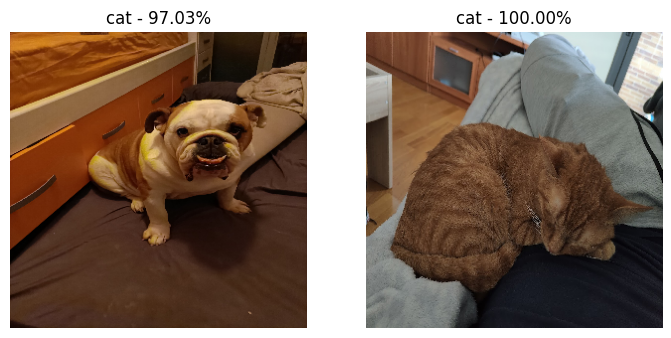

In [13]:
# Predicciones
import numpy as np

ruta_img_a_pred = ["oli.jpg", "gato.jpg"]
img_a_pred = []
array_img_a_pred = []

# Preprocesamiento
for imagen in ruta_img_a_pred:
    img = tf.keras.utils.load_img(imagen, target_size=(299, 299)) # Carga
    img_a_pred.append(img)
    img = tf.keras.utils.img_to_array(img) # Conv. a array
    img = np.expand_dims(img, axis=0) # (px, px, ch) -> (n, px, px, ch)
    img = tf.keras.applications.inception_v3.preprocess_input(img) # Preprocesamiento
    array_img_a_pred.append(img)

# Convertimos la lista de imagenes procesadas en un array de NP y los unimos verticalmente, uno después del otro.
array_img_a_pred = np.concatenate(array_img_a_pred, axis=0)

predicciones = modelo.predict(array_img_a_pred) # Hacemos predicciones

mejores_predicciones = np.argmax(predicciones, axis=-1) # Nos quedamos con la predicción con más probabilidad de cada uno.

# Visualización
plt.figure(figsize=(13, 8))
for i, (imagen, pred) in enumerate(zip(img_a_pred, mejores_predicciones)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imagen)
    plt.title(f"{clases[pred]} - {predicciones[i, pred]:.2%}")
    plt.axis("off")
plt.show()